In [1]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d

from pyhdf.SD import SD, SDC
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap, cm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense


2023-08-31 17:31:34.309558: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-31 17:31:34.338337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 17:31:34.481034: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 17:31:34.481610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 17:31:35.255795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:

# Assuming data_files is a list of your data filenames and mask_files is a list of your mask filenames
folder = "/home/filip/Documents/master_project/training_set/"
all_data = os.listdir(folder + "data/")
all_masks = os.listdir(folder + "mask/")

data_files = [f[:-4] for f in all_data]

data_list = []
mask_list = []

for file in data_files:
    image = np.load(folder + "data/" + file + ".npy")[::2, ::2]  # or any other method you use to read your data
    data_list.append(image)

for mask in data_files:
    mask_array = np.load(folder + "mask/" + mask + "_coords.npy")[::2, ::2]
    mask_list.append(mask_array)



min_shape = np.min([data.shape[0] for data in data_list]), np.min([data.shape[1] for data in data_list])
n_data = len(data_files)
X_full = np.empty((n_data, min_shape[0], min_shape[1]))
y_full = np.empty((n_data, min_shape[0], min_shape[1]))

for i in range(n_data):
    X_full[i] = data_list[i][:min_shape[0], :min_shape[1]]

for i in range(n_data):
    y_full[i] = mask_list[i][:min_shape[0], :min_shape[1]]

sum_mask = np.sum(np.sum(y_full, axis=1), axis=1)
outbreak_mask = np.argwhere(sum_mask != 0)[:,0]
X = X_full[outbreak_mask]
y = y_full[outbreak_mask]

print(X.shape)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)
for d in X:
    print(d.shape)
for d in y:
    print(d.shape)


(5, 1015, 677)
(1015, 677, 1)
(1015, 677, 1)
(1015, 677, 1)
(1015, 677, 1)
(1015, 677, 1)
(1015, 677, 1)
(1015, 677, 1)
(1015, 677, 1)
(1015, 677, 1)
(1015, 677, 1)


In [3]:
from keras.layers import Layer
import tensorflow as tf

class CustomUpSampling2D(Layer):
    def __init__(self, target_shape, **kwargs):
        self.target_shape = tuple(target_shape)
        super(CustomUpSampling2D, self).__init__(**kwargs)
    
    def call(self, inputs):
        return tf.image.resize(inputs, self.target_shape, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.target_shape[0], self.target_shape[1], input_shape[3])

X.shape[1]/2

507.5

In [4]:
from keras.layers import BatchNormalization, Dropout, add
from tensorflow.keras.optimizers import Adam
import keras 

def res_block(x, n_filters):
    """Utility function for creating a residual block."""
    y = Conv2D(n_filters, (3,3), activation='relu', padding='same')(x)
    y = BatchNormalization()(y)
    y = Conv2D(n_filters, (3,3), activation='relu', padding='same')(y)
    y = BatchNormalization()(y)
    return add([x, y])

# Model
input_img = keras.Input(shape=(X.shape[1], X.shape[2], 1))

# Initial convolution
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

# Residual block and more layers
x = res_block(x, 32)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.3)(x)

x = res_block(x, 64)
x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = CustomUpSampling2D((int(X.shape[1]/2), int(X.shape[2]/2)))(x) 
x = Dropout(0.3)(x)

x = res_block(x, 128)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = CustomUpSampling2D((X.shape[1], X.shape[2]))(x) 
x = Dropout(0.3)(x)

x = Conv2D(1, (1,1), activation='sigmoid')(x)

model = keras.Model(inputs=input_img, outputs=x)

optimizer = Adam(learning_rate=0.008) 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2], 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    CustomUpSampling2D((int(X.shape[1]/2), int(X.shape[2]/2))),  # Instead of UpSampling2D((2, 2))
    Conv2D(64, (3,3), activation='relu', padding='same'),
    CustomUpSampling2D((X.shape[1], X.shape[2])),  # Instead of UpSampling2D((2, 2))
    Conv2D(1, (1,1), activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(X.shape)
print(y.shape)
# Use a dummy input to propagate through the model, layer by layer
dummy_input = np.random.rand(1, X.shape[1], X.shape[2], 1)

# Examine the output shape after each layer
for layer in model.layers:
    dummy_input = layer(dummy_input)
    print(layer.name, dummy_input.shape)



(5, 2030, 1354, 1)
(5, 2030, 1354, 1)
conv2d_11 (1, 2030, 1354, 32)
max_pooling2d_2 (1, 1015, 677, 32)
conv2d_12 (1, 1015, 677, 64)
max_pooling2d_3 (1, 507, 338, 64)
conv2d_13 (1, 507, 338, 128)
custom_up_sampling2d_2 (1, 1015, 677, 128)
conv2d_14 (1, 1015, 677, 64)
custom_up_sampling2d_3 (1, 2030, 1354, 64)
conv2d_15 (1, 2030, 1354, 1)


In [5]:
# Parameters
batch_size = 32
epochs = 200

# Training the model
history = model.fit(X, y, 
                    batch_size=batch_size, 
                    epochs=epochs)#, 
                    #validation_data=(X, y))

Epoch 1/200
1/1 [==============================] - 9s 9s/step - loss: 0.9363 - accuracy: 0.4902
Epoch 2/200
1/1 [==============================] - 7s 7s/step - loss: 0.8857 - accuracy: 0.5163
Epoch 3/200
1/1 [==============================] - 8s 8s/step - loss: 1.5996 - accuracy: 0.5065
Epoch 4/200
1/1 [==============================] - 8s 8s/step - loss: 0.9810 - accuracy: 0.4236
Epoch 5/200
1/1 [==============================] - 8s 8s/step - loss: 0.8080 - accuracy: 0.5551
Epoch 6/200
1/1 [==============================] - 8s 8s/step - loss: 0.6476 - accuracy: 0.5928
Epoch 7/200
1/1 [==============================] - 8s 8s/step - loss: 0.5924 - accuracy: 0.6953
Epoch 8/200
1/1 [==============================] - 8s 8s/step - loss: 0.5550 - accuracy: 0.7641
Epoch 9/200
1/1 [==============================] - 8s 8s/step - loss: 0.5233 - accuracy: 0.8230
Epoch 10/200
1/1 [==============================] - 8s 8s/step - loss: 0.4982 - accuracy: 0.8771
Epoch 11/200


KeyboardInterrupt: 

In [27]:
y_pred = model.predict(X)

1/1 [==============================] - 1s 874ms/step


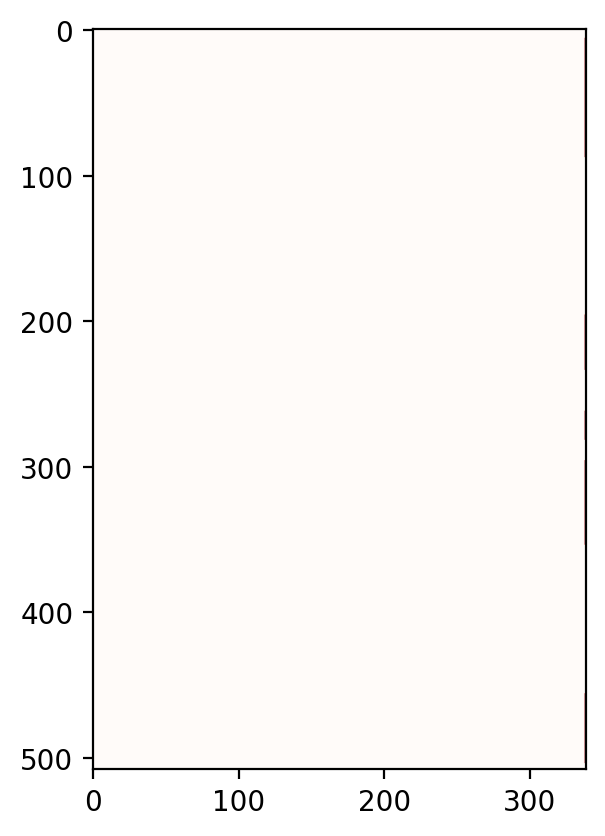

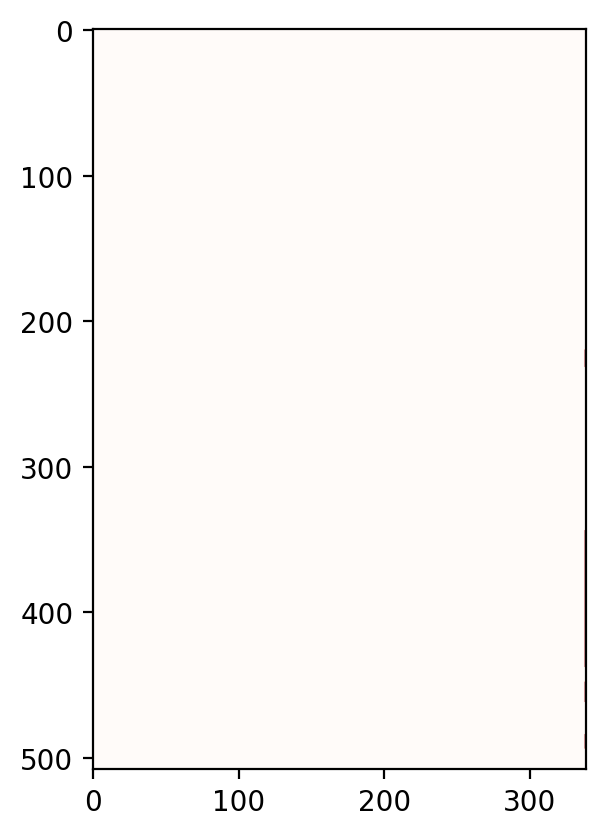

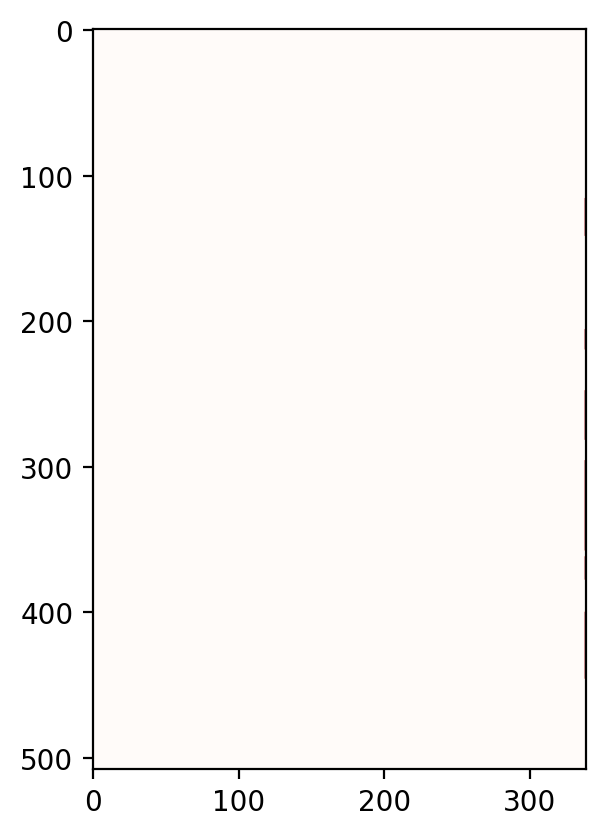

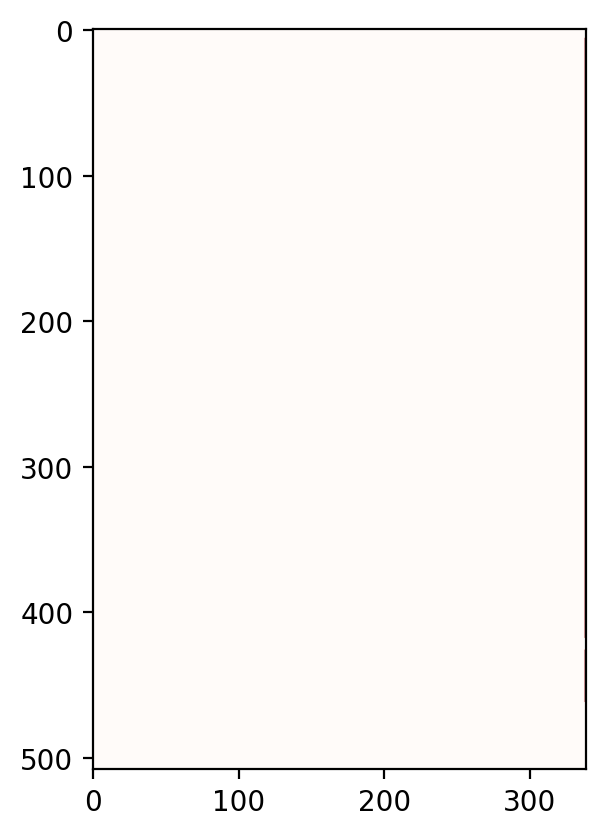

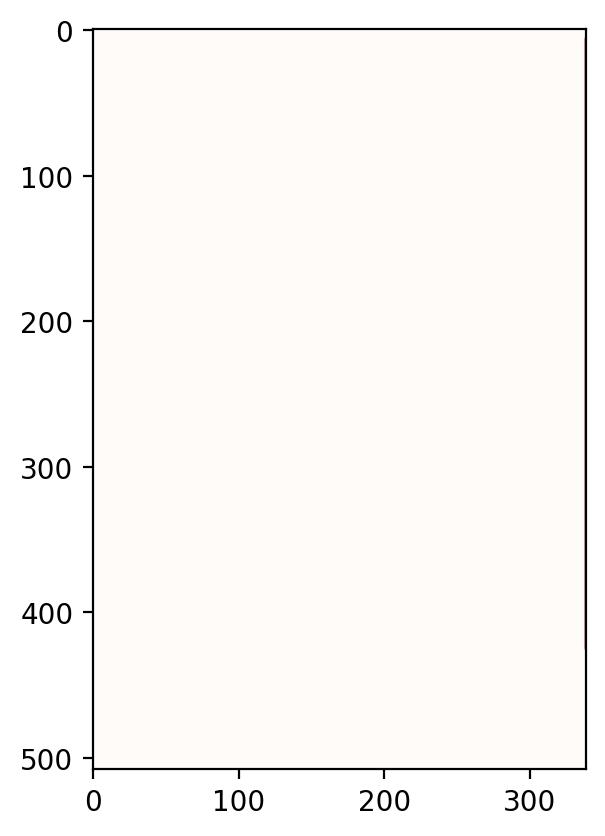

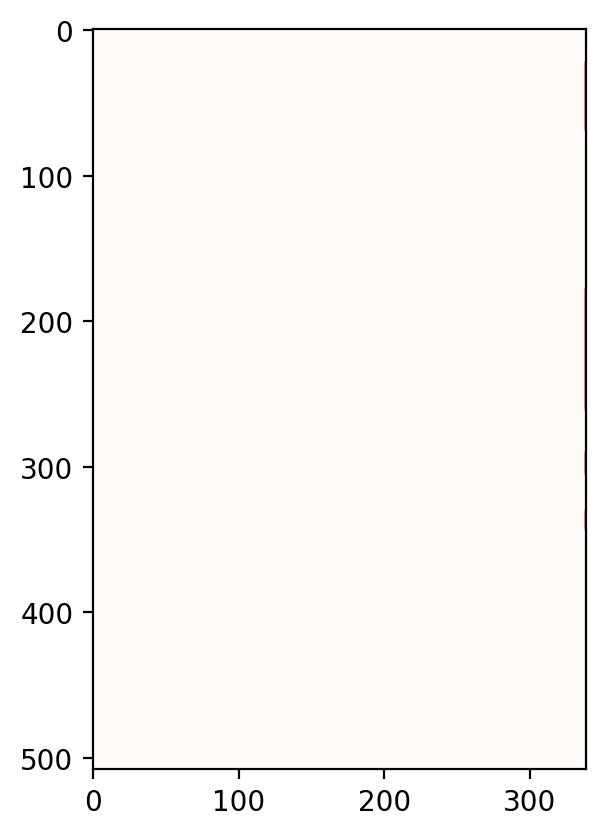

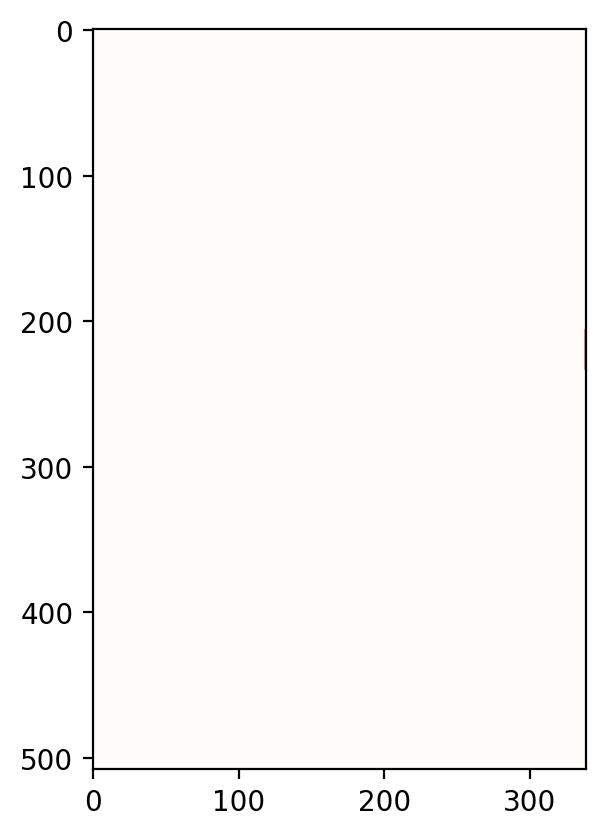

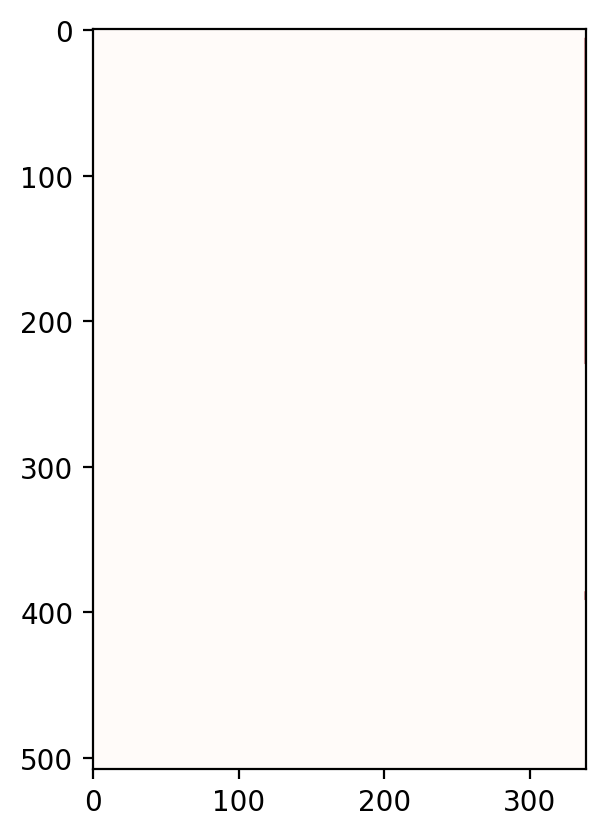

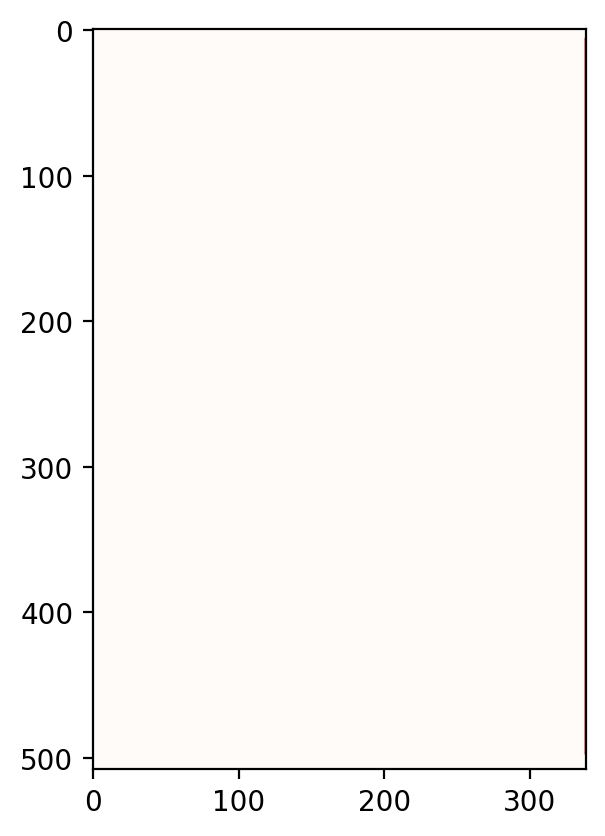

In [33]:
for pic in range(X.shape[0]):
    # plt.figure(dpi=200)
    # plt.imshow(X[pic, :,:,0], cmap="gray")
    # plt.imshow(y[pic, :,:,0], cmap="Reds", alpha=0.3)

    plt.figure(dpi=200)

    #plt.imshow(X[pic, :,:,0], cmap="gray")
    plt.imshow(y_pred[pic, :,:,0], cmap="Reds", alpha=0.4)

#plt.imshow(y[3, :,:,0], cmap="gray")
